In [21]:
import gcsfs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## [1] Load dataset

In [22]:
fs = gcsfs.GCSFileSystem()
print(fs.ls("gs://leap-persistent/sungdukyu"))
mapper = fs.get_mapper('leap-persistent/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_train_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_train_out = xr.open_dataset(mapper, engine='zarr', chunks={})

#<Saving toy dataset>
ds_train_in.isel(sample=slice(0,4)).to_zarr('./toy_dataset/E3SM-MMF_ne4.train.input.tiny.zarr')
ds_train_out.isel(sample=slice(0,4)).to_zarr('./toy_dataset/E3SM-MMF_ne4.train.output.tiny.zarr')

['leap-persistent/sungdukyu/E3SM-MMF_ne4.grid-info.zarr', 'leap-persistent/sungdukyu/E3SM-MMF_ne4.test.input.zarr', 'leap-persistent/sungdukyu/E3SM-MMF_ne4.test.output.zarr', 'leap-persistent/sungdukyu/E3SM-MMF_ne4.train.input.zarr', 'leap-persistent/sungdukyu/E3SM-MMF_ne4.train.output.zarr', 'leap-persistent/sungdukyu/testing']


## [2] Determine in/out variables; subsampling

#### Mooers et al. (2021) 
- SPCAM5.0
- 1.9 x 2.5 FV (=13,824 grid cells)
- 10 years long (= 4,843,929,600 columns simulated)
- 10 days subsampling (484,392,960) c.f. our total sample ne4 = 210240 sample * 384 col/sample = 80,732,160 cols
- dt = 15 min
- CRM: 32km (4km/dx * 8dx)
- Each of the input variables was pre-normalized before exposure to the neural network by subtracting its respective mean and dividing by its respective range, with these statistics computed and applied separately for each vertical level in the case of the vertically resolved temperature and humidity profiles (Table 2). The reason we divide by the range instead of the more traditional standard deviation, in line with the methods of Rasp et al. (2018), is to avoid dividing by near-zero numbers, for example, in the case of stratospheric humidity.
- Some previous aqua-planet experiments also used the meridional wind vertical profile as part of the input vector to the neural network, but it was omitted in this case as preliminary neural network tests indicate it had an insignificant effect on the skill of the trained network


<img src="Mooers_2021_variables.png"  width="70%">

From Mooers et al. 2021, https://doi.org/10.1029/2020MS002385

In [20]:
# in/out variable lists
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

In [10]:
# select ML variables
# note that otuput variables are tendencies, not state (for t and q)
mli = ds_train_in[vars_mli]
mlo = ds_train_out
mlo['ptend_t'] = (mli['state_t'] - mlo['state_t'])/1200 # T tendency [K/s]
mlo['ptend_q0001'] = (mli['state_q0001'] - mlo['state_q0001'])/1200 # Q tendency [kg/kg/s]
mlo = mlo[vars_mlo]

In [12]:
# sub sampling
if False: # this is only for the full dataset
    # One simulation day contains 72 samples (i.e., the model time step = 20 min)
    # Here, we are subsampling every 10 days
    t_ind = np.arange(len(mli['sample']))%(72*10)
    t_ind = t_ind<72

    mli = mli.sel(sample=t_ind)
    mlo = mlo.sel(sample=t_ind)

### [3] Input / output normalization

In [13]:
# Calculating norm factor
if False:
    # xarray ds
    var_mean={}
    var_std={}
    var_min={}
    var_max={}

    for kvar in vars_mli:
        var_mean[kvar] = ds_train_in[kvar].mean(dim=['sample','ncol'])
        var_std[kvar] = ds_train_in[kvar].std(dim=['sample','ncol'])
        var_min[kvar] = ds_train_in[kvar].min(dim=['sample','ncol'])
        var_max[kvar] = ds_train_in[kvar].max(dim=['sample','ncol'])

    mli_mean = xr.merge([ var_mean[kvar] for kvar in vars_mli ])
    mli_std = xr.merge([ var_std[kvar] for kvar in vars_mli ])
    mli_min = xr.merge([ var_min[kvar] for kvar in vars_mli ])
    mli_max = xr.merge([ var_max[kvar] for kvar in vars_mli ])
    mli_mean.to_netcdf('./norm_factors/mli_mean.nc')
    mli_std.to_netcdf('./norm_factors/mli_std.nc')
    mli_min.to_netcdf('./norm_factors/mli_min.nc')
    mli_max.to_netcdf('./norm_factors/mli_max.nc')
else:
    mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
    mli_std = xr.open_dataset('./norm_factors/mli_std.nc')
    mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
    mli_max = xr.open_dataset('./norm_factors/mli_max.nc')

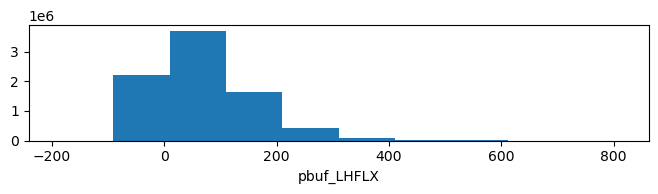

In [9]:
# histogram before norm (from the full dataset)
mli['pbuf_LHFLX'].plot.hist();
plt.gcf().set_size_inches(8,1.5)

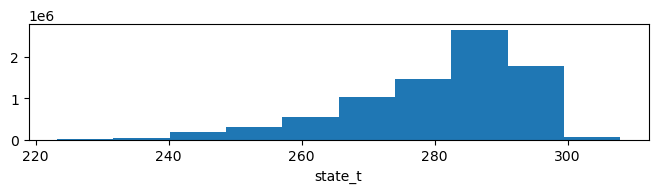

In [10]:
mli['state_t'].isel(lev=50).plot.hist();
plt.gcf().set_size_inches(8,1.5)

In [11]:
mli = (mli - mli_mean)/(mli_max - mli_min)

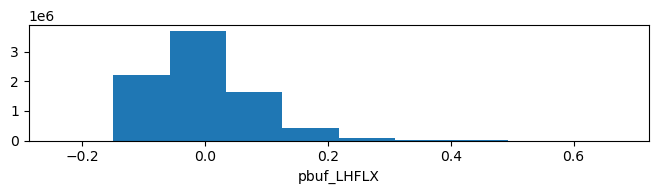

In [12]:
# histogram after norm (from the full dataset)
mli['pbuf_LHFLX'].plot.hist();
plt.gcf().set_size_inches(8,1.5)

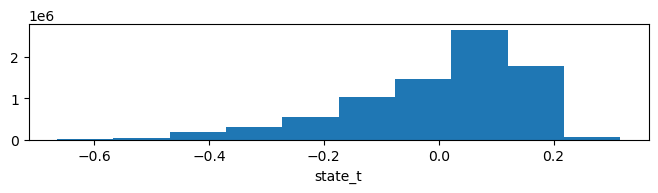

In [13]:
mli['state_t'].isel(lev=50).plot.hist();
plt.gcf().set_size_inches(8,1.5)

In [21]:
if True:
    mlo_scale = xr.Dataset({'ptend_t':        ('lev', 1.00464e3 * np.ones(mlo.dims['lev'])), # J/K/kg
                            'ptend_q0001':    ('lev', (2.501e6 + 3.337e5)*np.ones(mlo.dims['lev'])), # J/kg
                            'cam_out_NETSW':  1e-2 *0.24,
                            'cam_out_FLWDS':  1e-2 *.5,
                            'cam_out_PRECSC': 17280000 * .72,
                            'cam_out_PRECC':  1728000 * .76,
                            'cam_out_SOLS':   1e-2 * .5,
                            'cam_out_SOLL':   1e-2 * .46,
                            'cam_out_SOLSD':  1e-2 * .61,
                            'cam_out_SOLLD':  1e-2 * .95
                           })
    mlo_scale.to_netcdf('./norm_factors/mlo_scale.nc')
else:
    mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')

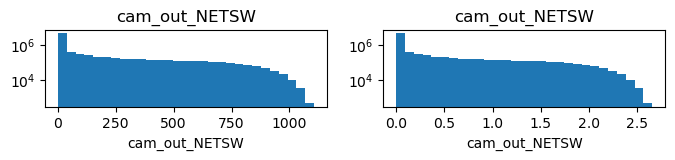

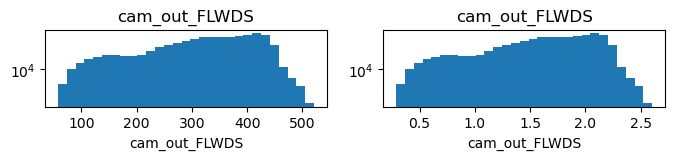

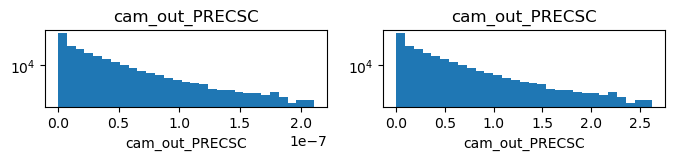

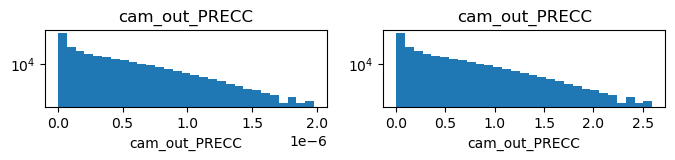

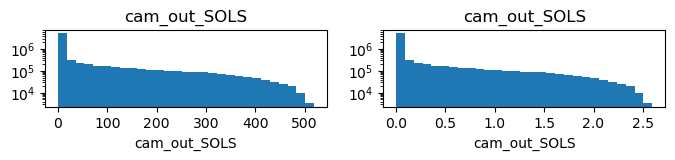

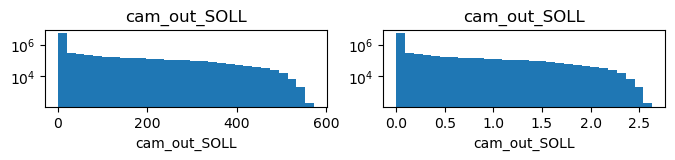

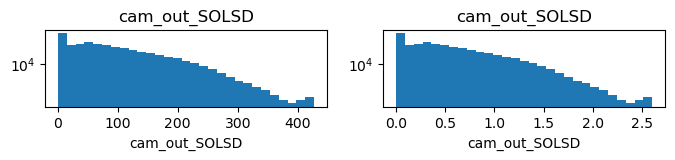

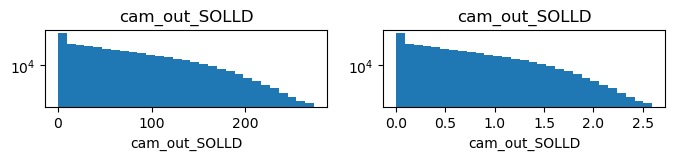

In [13]:
# before and after output scaling
for kvar in ['cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']:
    fig, ax_ = plt.subplots(ncols=2)
    ax = ax_[0]
    mlo[kvar].plot.hist(bins=29,ax=ax)
    ax.set_title(kvar)
    ax.set_yscale('log')
    fig.set_size_inches(8,1.5)
    ax = ax_[1]
    (mlo[kvar]*mlo_scale[kvar]).plot.hist(bins=29,ax=ax)
    ax.set_title(kvar)
    ax.set_yscale('log')
    fig.set_size_inches(8,1)

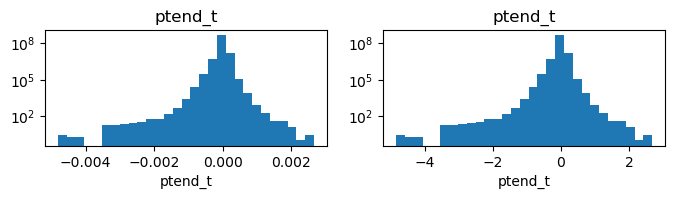

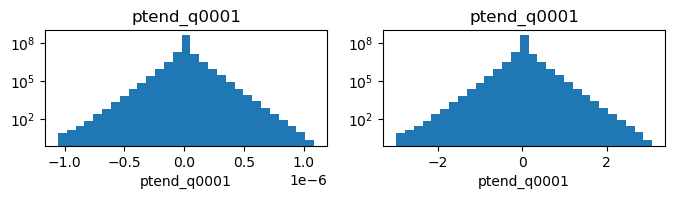

In [14]:
for kvar in ['ptend_t', 'ptend_q0001']:
    fig, ax_ = plt.subplots(ncols=2)
    ax = ax_[0]
    mlo[kvar].plot.hist(bins=29,ax=ax)
    ax.set_title(kvar)
    ax.set_yscale('log')
    ax = ax_[1]
    (mlo[kvar]*mlo_scale[kvar]).plot.hist(bins=29,ax=ax)
    ax.set_title(kvar)
    ax.set_yscale('log')
    fig.set_size_inches(8,1.5)

In [15]:
mlo = mlo*mlo_scale

### [5] build model

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# params
input_length = 2*60 + 4
output_length_lin  = 2*60
output_length_relu = 8
output_length = output_length_lin + output_length_relu
n_nodes = 2

# constrcut a model
input_layer    = keras.layers.Input(shape=(input_length,), name='input')
hidden_0       = keras.layers.Dense(n_nodes, activation='relu')(input_layer)
hidden_1       = keras.layers.Dense(n_nodes, activation='relu')(hidden_0)
output_pre     = keras.layers.Dense(output_length, activation='elu')(hidden_1)
output_lin     = keras.layers.Dense(output_length_lin,activation='linear')(output_pre)
output_relu    = keras.layers.Dense(output_length_relu,activation='relu')(output_pre)
output_layer   = keras.layers.Concatenate()([output_lin, output_relu])

model = keras.Model(input_layer, output_layer, name='Emulator')

# input_layer    = keras.layers.Input(shape=(input_length,), name='input')
# hidden_0       = keras.layers.Dense(128, activation='relu')(input_layer)
# model = keras.Model(input_layer, hidden_0, name='Emulator')

model.summary()

# compile
model.compile(optimizer=keras.optimizers.Adam(), #optimizer=keras.optimizers.Adam(learning_rate=clr),
              loss='mse',
              metrics=['mse','mae','accuracy'])

Model: "Emulator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 124)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 2)            250         ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 2)            6           ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          384         ['dense_1[0][0]']                
                                                                                           

In [17]:
# from here we are using a toy dataset (0.15% of the whole dataset, e.g., sample: 320 vs 210,240)
ds_train_in_toy = xr.open_dataset('./toy_dataset/E3SM-MMF_ne4.train.input.tiny.zarr', engine='zarr')
ds_train_out_toy = xr.open_dataset('./toy_dataset/E3SM-MMF_ne4.train.output.tiny.zarr', engine='zarr')

# normalize , scale
mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
mli_std = xr.open_dataset('./norm_factors/mli_std.nc')
mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
mli_max = xr.open_dataset('./norm_factors/mli_max.nc')
mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')

mli_toy = ds_train_in_toy[vars_mli]
mlo_toy = ds_train_out_toy
mlo_toy['ptend_t'] = (mli_toy['state_t'] - mlo_toy['state_t'])/1200 # T tendency [K/s]
mlo_toy['ptend_q0001'] = (mli_toy['state_q0001'] - mlo_toy['state_q0001'])/1200 # Q tendency [kg/kg/s]
mlo_toy = mlo_toy[vars_mlo]
mli_toy = (mli_toy - mli_mean)/(mli_max - mli_min)
mlo_toy = mlo_toy*mlo_scale

In [11]:
# split train vs validation
split = .8

n_subset = len(mli_toy['sample'])
ind_split = int(n_subset*split)

x_train = mli_toy.isel(sample=slice(None,ind_split))
y_train = mlo_toy.isel(sample=slice(None,ind_split))
x_val = mli_toy.isel(sample=slice(ind_split,None))
y_val = mlo_toy.isel(sample=slice(ind_split,None))

In [12]:
# now dataset has 3 dims
x_train.dims

Frozen({'sample': 256, 'lev': 60, 'ncol': 384})

In [13]:
# we want to make the dataset to stacked 2 dimnesional tensor,
# "batch" dimension": stacked "sample" and "ncol"
x_train = x_train.stack({'batch':{'sample','ncol'}})
y_train = y_train.stack({'batch':{'sample','ncol'}})
x_val = x_val.stack({'batch':{'sample','ncol'}})
y_val = y_val.stack({'batch':{'sample','ncol'}})
x_train

<xarray.Dataset>
Dimensions:      (lev: 60, batch: 98304)
Coordinates:
  * batch        (batch) object MultiIndex
  * ncol         (batch) int64 0 0 0 0 0 0 0 0 ... 383 383 383 383 383 383 383
  * sample       (batch) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
Dimensions without coordinates: lev
Data variables:
    state_t      (lev, batch) float64 -0.00152 -0.001585 ... -0.1294 -0.1298
    state_q0001  (lev, batch) float64 -0.2471 -0.2473 ... -0.2695 -0.2697
    state_ps     (batch) float64 0.07086 0.07027 0.06973 ... 0.008052 0.008447
    pbuf_SOLIN   (batch) float64 -0.2422 -0.2422 -0.2422 ... -0.2422 -0.2422
    pbuf_LHFLX   (batch) float64 0.01537 0.01417 0.01297 ... -0.03511 -0.0346
    pbuf_SHFLX   (batch) float64 -0.01913 -0.01912 -0.01908 ... 0.00616 0.006622

In [14]:
# The input variables are stored separately
# now we want to stack them into a single 'collective' variable,
# e.g., inputvar = [*state_t(lev) *state_q0001(lev) state_ps pbuf_SOLIN ... ]
x_train = x_train.to_stacked_array("mlvar", sample_dims=["batch"])
y_train = y_train.to_stacked_array("mlvar", sample_dims=["batch"])
x_val = x_val.to_stacked_array("mlvar", sample_dims=["batch"])
y_val = y_val.to_stacked_array("mlvar", sample_dims=["batch"])
x_train

<xarray.DataArray 'state_t' (batch: 98304, mlvar: 124)>
array([[-0.00152047, -0.02064619, -0.04413677, ..., -0.24221587,
         0.01536881, -0.01913033],
       [-0.00158477, -0.02135921, -0.04700137, ..., -0.24221587,
         0.01416521, -0.01912217],
       [-0.0016169 , -0.02162365, -0.04940937, ..., -0.24221587,
         0.01296718, -0.01908157],
       ...,
       [ 0.00156657, -0.00951264, -0.0057112 , ..., -0.24221587,
        -0.03504467,  0.00534142],
       [ 0.00157491, -0.00800742, -0.00433624, ..., -0.24221587,
        -0.03510665,  0.00615997],
       [ 0.0015644 , -0.00688371, -0.00299356, ..., -0.24221587,
        -0.03459762,  0.00662205]])
Coordinates:
  * batch     (batch) object MultiIndex
  * ncol      (batch) int64 0 0 0 0 0 0 0 0 ... 383 383 383 383 383 383 383 383
  * sample    (batch) int64 0 1 2 3 4 5 6 7 ... 248 249 250 251 252 253 254 255
  * mlvar     (mlvar) object MultiIndex
  * variable  (mlvar) object 'state_t' 'state_t' ... 'pbuf_LHFLX' 'pbuf_SHFLX'
  * lev       (mlvar) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 59.0 nan nan nan nan

In [15]:
model.fit(x_train.values,y_train.values, batch_size=128)

2023-05-09 19:59:55.477845: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2023-05-09 19:59:55.479521: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-05-09 19:59:55.479906: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-05-09 19:59:55.503005: W tensorflow/compiler/xla/service/gpu/llvm_gpu_b

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/srv/conda/envs/notebook/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/srv/conda/envs/notebook/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4544/761108083.py", line 1, in <module>
      model.fit(x_train.values,y_train.values, batch_size=128)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_1364]